## Sequence Prediction and Topology Imputation using Transformer Models

This notebook presents a comprehensive approach to building, training, and evaluating a Transformer-based model designed to predict the next node in a sequence of network nodes. The sequences represent paths in a network, and the nodes are routers (from a traceroute path) identified by unique IDs.

The primary goal is to reconstruct the network topology by imputing missing or unknown nodes based on the model's predictions. By accurately predicting these nodes, we aim to enhance the representation of the network's structure, leading to improved understanding and builing the foundations for more complex models and in-depth analysis of other network metrics.

The first version of the model does not let UNK nodes to be set as target values. Such aaproach works generally, but does not cover corner cases such as constantly missing nodes and a sequence of missing nodes. Next version will attempt to include those as well.










First - load the dataset

In [1]:
from collector import DataCollector

# save the dataset to a file
# period = ['2024-09-07T06:22:19.000Z', '2024-09-30T06:22:19.000Z']
# collector = DataCollector(period=period, ip_version='ipv4', save_to_file=True)
# collector.run()

# оr read from а saved file
sample_ipv4 = DataCollector(ip_version='ipv4').run()
sample_ipv4.head()

Success


,traceroute_ts,throughput_ts,ttls-hops_hash,src,dest,throughput_Mb,path_complete,destination_reached,route-sha1,ipv6,...,ttl,asn,rtt,src_site,dest_site,similarity_score,stable,timestamp,private,rounded_throughput_ts
0,2024-09-08T22:29:11.000Z,2024-09-08 22:36:31+00:00,8fa97eff1018acdbc0e60d479d6ae13ddc8682a0,159.93.229.150,109.105.124.88,3420,1,1,be0962b8fcd2f6a3f7a741e0d66847509baf6aaf,False,...,1,2875,0.5,JINR-T1-LHCOPNE,NDGF-T1,1.0,1,1725834991,0,2024-09-08 22:00:00+00:00
1,2024-09-08T22:29:11.000Z,2024-09-08 22:36:31+00:00,8fa97eff1018acdbc0e60d479d6ae13ddc8682a0,159.93.229.150,109.105.124.88,3420,1,1,be0962b8fcd2f6a3f7a741e0d66847509baf6aaf,False,...,2,0,0.7,JINR-T1-LHCOPNE,NDGF-T1,1.0,1,1725834991,1,2024-09-08 22:00:00+00:00
2,2024-09-08T22:29:11.000Z,2024-09-08 22:36:31+00:00,8fa97eff1018acdbc0e60d479d6ae13ddc8682a0,159.93.229.150,109.105.124.88,3420,1,1,be0962b8fcd2f6a3f7a741e0d66847509baf6aaf,False,...,3,513,0.2,JINR-T1-LHCOPNE,NDGF-T1,1.0,1,1725834991,0,2024-09-08 22:00:00+00:00
3,2024-09-08T22:29:11.000Z,2024-09-08 22:36:31+00:00,8fa97eff1018acdbc0e60d479d6ae13ddc8682a0,159.93.229.150,109.105.124.88,3420,1,1,be0962b8fcd2f6a3f7a741e0d66847509baf6aaf,False,...,4,513,46.6,JINR-T1-LHCOPNE,NDGF-T1,1.0,1,1725834991,0,2024-09-08 22:00:00+00:00
4,2024-09-08T22:29:11.000Z,2024-09-08 22:36:31+00:00,8fa97eff1018acdbc0e60d479d6ae13ddc8682a0,159.93.229.150,109.105.124.88,3420,1,1,be0962b8fcd2f6a3f7a741e0d66847509baf6aaf,False,...,5,513,46.7,JINR-T1-LHCOPNE,NDGF-T1,1.0,1,1725834991,0,2024-09-08 22:00:00+00:00


In [2]:
import torch

if torch.cuda.is_available():
    print(f"CUDA is available. GPU count: {torch.cuda.device_count()}")
    print(f"Current GPU device: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available. No GPU detected.")


CUDA is available. GPU count: 1
Current GPU device: NVIDIA GeForce GTX 1080 Ti


In [3]:
sample_ipv4.throughput_ts.min(), sample_ipv4.throughput_ts.max()

(Timestamp('2024-09-07 06:27:10+0000', tz='UTC'),
 Timestamp('2024-09-29 22:59:33+0000', tz='UTC'))

Use Dask to insert the missing positions by finding the omitted TTLs

In [4]:
import pandas as pd
import dask.dataframe as dd
from dask.distributed import Client

# Connect to the running Dask cluster using the scheduler address
client = Client('tcp://127.0.0.1:40473')

df = sample_ipv4.copy()
df.sort_values(by=['traceroute_ts', 'ttls-hops_hash', 'ttl'], inplace=True)
df['anonymous'] = 0
df['max_ttl'] = df.groupby('ttls-hops_hash')['ttl'].transform(max)
ddf = dd.from_pandas(df, npartitions=8)


# Define the function to fill missing TTLs
def fill_missing_ttl(group):
    group = group.sort_values(by='ttl')
    complete_range = pd.RangeIndex(start=group['ttl'].min(), stop=group['ttl'].max() + 1)

    missing_ttl = complete_range.difference(group['ttl'])

    rows_to_add = []
    for ttl in missing_ttl:
        previous_row = group.iloc[0]
        new_row = previous_row.copy()
        new_row['ttl'] = ttl
        new_row['anonymous'] = 1
        new_row['router'] = 'unknown'
        rows_to_add.append(new_row)

    return pd.concat([group, pd.DataFrame(rows_to_add)], ignore_index=True).sort_values(by='ttl')



# Grouping and applying the function using Dask's map_partitions
# Convert the grouped Dask DataFrame back to pandas for processing
def process_partition(partition):
    # Group by traceroute_ts and ttls-hops_hash within each partition
    return partition.groupby(['traceroute_ts', 'ttls-hops_hash']).apply(fill_missing_ttl)

# Use map_partitions to parallelize the function across partitions
filled_dask = ddf.map_partitions(process_partition, meta=df)

# Convert back to pandas DataFrame if needed
filled_ipv4 = filled_dask.compute()
filled_ipv4.drop(columns=['traceroute_ts', 'ttls-hops_hash'], inplace=True)
filled_ipv4.reset_index(inplace=True)

/usr/local/lib/python3.8/dist-packages/distributed/client.py:3108: UserWarning: Sending large graph of size 58.73 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Next code puts each node into context by taking previous and next node. In the end all nodes have a unique ID depending on where they appear on the network. This is done primarily in order to analyse the unknown nodes

In [5]:
# give the routers short IDs for simplicity and easy visualization
unique_routers = list(set(list(sample_ipv4['router'].unique()) + list(sample_ipv4['src'].unique()) + list(sample_ipv4['dest'].unique())))
router_map = {router: f'r{i+1}' for i, router in enumerate(unique_routers)}
filled_ipv4['rid'] = filled_ipv4['router'].map(lambda x: router_map.get(x))


filled_ipv4.sort_values(by=['traceroute_ts', 'ttls-hops_hash', 'ttl'], inplace=True)
filled_ipv4['prev_router'] = filled_ipv4.groupby(['traceroute_ts', 'ttls-hops_hash'])['rid'].shift(1)
filled_ipv4['next_router'] = filled_ipv4.groupby(['traceroute_ts', 'ttls-hops_hash'])['rid'].shift(-1)

# # Define a function to apply the conditional logic for setting 'next_router'
def set_next_router(row):
    if row['ttl'] == row['max_ttl'] and row['destination_reached'] == 1:
        return router_map.get(row['dest'])
    return row.get('next_router', 'unknown')  # Return existing 'next_router' or 'unknown' if not present

filled_ipv4['next_router'] = filled_ipv4.apply(set_next_router, axis=1)

filled_ipv4['prev_router'].fillna('unknown', inplace=True)
filled_ipv4['rid'].fillna('unknown', inplace=True)
filled_ipv4['next_router'].fillna('unknown', inplace=True)
filled_ipv4['prev_router'] = filled_ipv4['prev_router'].astype(str)
filled_ipv4['next_router'] = filled_ipv4['next_router'].astype(str)

filled_ipv4['unique_id'] = filled_ipv4['prev_router'] + '-' + filled_ipv4['rid'] + '-' + filled_ipv4['next_router']

filled_ipv4['next'] = filled_ipv4.groupby(['traceroute_ts', 'ttls-hops_hash'])['unique_id'].shift(-1)
filled_ipv4['curr'] = filled_ipv4['rid']

filled_ipv4.loc[filled_ipv4['anonymous']==1, 'curr'] = filled_ipv4[filled_ipv4['anonymous']==1]['unique_id']

# unknown IPs should be considered in a context
filled_ipv4['next'] = filled_ipv4.groupby(['traceroute_ts', 'ttls-hops_hash'])['curr'].shift(-1)

def set_next_router(row):
    # if the last node was reached and the destination was reached, set the next = destination
    if row['ttl'] == row['max_ttl'] and row['destination_reached'] == 1:
        return router_map.get(row['dest'])
    return row.get('next')  # Return existing 'next_router' or 'unknown' if not present

filled_ipv4['next'] = filled_ipv4.apply(set_next_router, axis=1)

ddf = filled_ipv4[(filled_ipv4['curr'] != 'unknown-unknown-unknown')].copy()

# prepare to build the trasition datatset by removing the unknowns and the loops
ddf = ddf[(ddf['rid'] != 'unknown') & (ddf['next_router'] != 'unknown')]
ddf = ddf[(ddf['rid'] != 'next_router')]


# Count occurrences of each transition pair
transition_counts = ddf.groupby(['rid', 'next_router']).size().reset_index(name='count')

# Calculate the total number of transitions from each router
total_transitions = transition_counts.groupby('rid')['count'].sum().reset_index(name='total')

# Merge back to calculate probabilities
transition_counts = transition_counts.merge(total_transitions, on='rid')
transition_counts['probability'] = transition_counts['count'] / transition_counts['total']

# Restructure data for easy access (optional)
transition_probabilities = transition_counts.pivot(index='rid', columns='next_router', values='probability').fillna(0)

Create the sequences by grouping the nodes 

In [6]:
filled_ipv4.sort_values(['src', 'dest', 'traceroute_ts', 'ttls-hops_hash', 'ttl'], inplace=True)
grouped_paths = filled_ipv4[['src_site', 'dest_site', 'throughput_ts','ttls-hops_hash', 'curr', 'ttl',
                             'private', 'anonymous', 'similarity_score', 'path_complete']]\
                            .drop_duplicates()\
                            .groupby(['src_site', 'dest_site', 'throughput_ts','ttls-hops_hash', 'similarity_score', 'path_complete'])[['curr', 'ttl', 'private', 'anonymous']]\
                            .agg(list)\
                            .reset_index()

print(f'Length before: {len(grouped_paths)}')
grouped_paths['node_confidence']  = grouped_paths['anonymous'].apply(lambda l: [0.01 if a == 1 else 1 for a in l])
display(grouped_paths.head(2))
df = grouped_paths.copy()
# df = grouped_paths.drop_duplicates(subset=['ttls-hops_hash']).copy()

Length before: 26993


,src_site,dest_site,throughput_ts,ttls-hops_hash,similarity_score,path_complete,curr,ttl,private,anonymous,node_confidence
0,BEIJING-LCG2,BEGRID-ULB-VUB,2024-09-08 02:36:38+00:00,849778294042c57fbc6928e6aa565d534798bd09,1.0,0,"[r644, r704, r441, r483, r208, r835, r640, r98...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0.01, 1, 0.0..."
1,BEIJING-LCG2,BEGRID-ULB-VUB,2024-09-09 20:14:12+00:00,849778294042c57fbc6928e6aa565d534798bd09,1.0,0,"[r644, r704, r441, r483, r208, r835, r640, r98...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0.01, 1, 0.0..."


In [7]:
from sklearn.preprocessing import LabelEncoder

def tokenize_nodes(df):
    # Flatten the node list to create a vocabulary
    all_nodes = [node for sublist in df['curr'] for node in sublist]

    le = LabelEncoder()

    # Fit the LabelEncoder on all nodes and transform them into tokens
    le.fit(all_nodes)
    df['tokenized_curr'] = df['curr'].apply(lambda x: le.transform(x))

    # Add a padding token at index 0 (optional, LabelEncoder starts at 0 by default)
    token_to_node = {index: node for index, node in enumerate(le.classes_)}

    return df, le, token_to_node

# Tokenize the nodes
df, le, token_to_node = tokenize_nodes(df)
df[['curr', 'tokenized_curr']].head()


,curr,tokenized_curr
0,"[r644, r704, r441, r483, r208, r835, r640, r98...","[1512, 1611, 1158, 1233, 731, 1831, 1505, 2106..."
1,"[r644, r704, r441, r483, r208, r835, r640, r98...","[1512, 1611, 1158, 1233, 731, 1831, 1505, 2106..."
2,"[r644, r704, r441, r483, r208, r835, r640, r98...","[1512, 1611, 1158, 1233, 731, 1831, 1505, 2106..."
3,"[r644, r704, r441, r483, r208, r835, r640, r98...","[1512, 1611, 1158, 1233, 731, 1831, 1505, 2106..."
4,"[r644, r644-unknown-r441, r441, r483, r208, r8...","[1512, 1514, 1158, 1233, 731, 1831, 1505, 2106..."


In [8]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def pad_sequences_fn(df):
    # Pad sequences so that they are of equal length
    df['padded_curr'] = pad_sequences(df['tokenized_curr'], padding='post', value=0).tolist()
    max_len = max(df['padded_curr'].apply(len))

    return df, max_len

# Pad the tokenized sequences
df, max_len = pad_sequences_fn(df)
print(df[['tokenized_curr', 'padded_curr']].head(1).to_dict('records'))
df[['tokenized_curr', 'padded_curr']].head()


2024-10-02 18:35:16.923181: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-02 18:35:17.706261: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[{'tokenized_curr': array([1512, 1611, 1158, 1233,  731, 1831, 1505, 2106, 1522, 1843, 1765,
       1766,  327,  328,  829]), 'padded_curr': [1512, 1611, 1158, 1233, 731, 1831, 1505, 2106, 1522, 1843, 1765, 1766, 327, 328, 829, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}]


,tokenized_curr,padded_curr
0,"[1512, 1611, 1158, 1233, 731, 1831, 1505, 2106...","[1512, 1611, 1158, 1233, 731, 1831, 1505, 2106..."
1,"[1512, 1611, 1158, 1233, 731, 1831, 1505, 2106...","[1512, 1611, 1158, 1233, 731, 1831, 1505, 2106..."
2,"[1512, 1611, 1158, 1233, 731, 1831, 1505, 2106...","[1512, 1611, 1158, 1233, 731, 1831, 1505, 2106..."
3,"[1512, 1611, 1158, 1233, 731, 1831, 1505, 2106...","[1512, 1611, 1158, 1233, 731, 1831, 1505, 2106..."
4,"[1512, 1514, 1158, 1233, 731, 1831, 1505, 2106...","[1512, 1514, 1158, 1233, 731, 1831, 1505, 2106..."


In [9]:
def generate_attention_masks(df, max_len):
    # Create attention masks where 1 indicates actual data and 0 indicates padding
    df['attention_mask'] = df['padded_curr'].apply(lambda x: [1 if i != 0 else 0 for i in x])
    return df

# Generate attention masks
df = generate_attention_masks(df, max_len)
df[['padded_curr', 'attention_mask']].head()


,padded_curr,attention_mask
0,"[1512, 1611, 1158, 1233, 731, 1831, 1505, 2106...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,"[1512, 1611, 1158, 1233, 731, 1831, 1505, 2106...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,"[1512, 1611, 1158, 1233, 731, 1831, 1505, 2106...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,"[1512, 1611, 1158, 1233, 731, 1831, 1505, 2106...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,"[1512, 1514, 1158, 1233, 731, 1831, 1505, 2106...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [10]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

def prepare_input_target_data(df):
    input_data = []
    target_data = []
    confidence_data = []

    for index, row in df.iterrows():

        for i in range(1, len(row['tokenized_curr'])):
            input_seq = row['tokenized_curr'][:i]
            target_node = row['tokenized_curr'][i]
            input_confidence = row['node_confidence'][:i]
            is_anonymous = row['anonymous'][i]

            # do not let the padded values or the anonymous nodes to be set as target values
            if target_node!= 0 and is_anonymous==0:
                input_data.append(input_seq)
                # print(input_seq)
                target_data.append(target_node)
                # print('target:', target_node,'\n')
                confidence_data.append(input_confidence)

    # Ensure confidence data is a list of floats before padding
    confidence_data = [np.array(conf).astype(np.float32) for conf in confidence_data]

    # Pad input sequences again to ensure uniform length
    input_data_padded = pad_sequences(input_data, maxlen=max_len, padding='post', value=0)
    confidence_data_padded = pad_sequences(confidence_data, maxlen=max_len, padding='post', value=0, dtype='float32')

    return input_data_padded, target_data, confidence_data_padded

# Prepare input, target, and confidence data
input_data_padded, target_data, confidence_data_padded = prepare_input_target_data(df)

In [11]:
def generate_attention_masks_for_segments(input_data_padded, max_len):
    attention_masks = []

    for sequence in input_data_padded:
        mask = [1 if token != 0 else 0 for token in sequence]
        attention_masks.append(mask)

    return attention_masks

masks = generate_attention_masks_for_segments(input_data_padded, max_len)

print(f"Input Data Shape: {input_data_padded.shape}")
print(f"Target Data Shape: {len(target_data)}")

Input Data Shape: (294253, 30)
Target Data Shape: 294253


In [12]:
import logging

# Configure logging
logging.basicConfig(
    filename='training_debug.log',
    filemode='w',                     # Overwrite the file on each run; use 'a' to append
    format='%(asctime)s - %(message)s',
    level=logging.DEBUG
)


In [13]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn

def custom_loss_function(outputs, target_batch, confidence_batch):
    # Get the logits for the last non-padded token
    # First, find the length of each sequence (excluding padding)
    input_lengths = (input_batch != 0).sum(dim=1)  # Shape: (batch_size,)
    # Get the logits at the last non-padded positions
    last_outputs = outputs[range(outputs.size(0)), input_lengths - 1]  # Shape: (batch_size, vocab_size)
    # Compute loss
    loss_fn = nn.CrossEntropyLoss()
    loss = loss_fn(last_outputs, target_batch)
    return loss


# Set the number of threads PyTorch should use
torch.set_num_threads(30)
torch.set_num_interop_threads(30)
print(f"Using {torch.get_num_threads()} threads for PyTorch operations")

# Convert to tensors
input_tensor = torch.tensor(input_data_padded, dtype=torch.long)
target_tensor = torch.tensor(target_data, dtype=torch.long)
confidence_tensor = torch.tensor(confidence_data_padded, dtype=torch.float32)
attention_masks_tensor = (input_tensor != 0).long()



# Create a TensorDataset, replace the attention mask with the confidence (the confidence is not in use currently)
dataset = TensorDataset(input_tensor, attention_masks_tensor, target_tensor, confidence_tensor)

# Prepare DataLoader with multiple workers
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=16)

# Define the Transformer model (from your previous steps)
class TransformerModel(nn.Module):
    def __init__(self, vocab_size, embed_size, num_heads, num_layers, max_len, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=0)
        self.pos_embedding = nn.Embedding(max_len, embed_size)
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(embed_size, num_heads, dim_feedforward=embed_size * 4, dropout=dropout),
            num_layers
        )
        self.fc = nn.Linear(embed_size, vocab_size)

    def forward(self, src, src_mask):
        batch_size, seq_len = src.size()
        pos = torch.arange(0, seq_len, device=src.device).unsqueeze(0).repeat(batch_size, 1)
        src = self.embedding(src) + self.pos_embedding(pos)
        src = src.permute(1, 0, 2)  # Transformer expects input as (seq_len, batch_size, embed_size)
        output = self.transformer_encoder(src, src_key_padding_mask=src_mask)
        output = output.permute(1, 0, 2)  # Change back to (batch_size, seq_len, embed_size)
        output = self.fc(output)  # Final layer to get vocab_size logits per position
        return output


class TransformerModel(nn.Module):
    def __init__(self, vocab_size, embed_size, num_heads, num_layers, max_len, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=0)
        self.pos_embedding = nn.Embedding(max_len, embed_size)
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(embed_size, num_heads, dim_feedforward=embed_size * 4, dropout=dropout),
            num_layers
        )
        self.fc = nn.Linear(embed_size, vocab_size)

    def forward(self, src, src_mask):
        batch_size, seq_len = src.size()
        pos = torch.arange(0, seq_len, device=src.device).unsqueeze(0).repeat(batch_size, 1)
        src = self.embedding(src) + self.pos_embedding(pos)
        src = src.permute(1, 0, 2)  # Transformer expects input as (seq_len, batch_size, embed_size)
        output = self.transformer_encoder(src, src_key_padding_mask=src_mask)
        output = output.permute(1, 0, 2)  # Change back to (batch_size, seq_len, embed_size)
        output = self.fc(output)  # Final layer to get vocab_size logits per position
        return output



Using 1 threads for PyTorch operations


In [14]:
i = np.random.randint(len(target_data))
i, confidence_data_padded[i], input_data_padded[i], target_data[i], attention_masks_tensor[i]

(206472,
 array([1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 array([1143, 1711,    5, 1026,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0], dtype=int32),
 1329,
 tensor([1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0]))

In [ ]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Hyperparameters
vocab_size = input_tensor.max().item() + 1
embed_size = 128
num_heads = 8
num_layers = 4
max_len = input_tensor.shape[1]
dropout = 0.1
learning_rate = 0.0001
epochs = 100

# Initialize model, optimizer
model = TransformerModel(vocab_size=vocab_size, embed_size=embed_size, num_heads=num_heads, num_layers=num_layers, max_len=max_len, dropout=dropout)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


# attention_masks_tensor = confidence_tensor
# Split the data into training and validation sets
train_inputs, val_inputs, train_masks, val_masks, train_targets, val_targets, train_confidences, val_confidences = train_test_split(
    input_tensor, attention_masks_tensor, target_tensor, confidence_tensor, test_size=0.2, random_state=42)

# Create TensorDatasets for training and validation sets
train_dataset = TensorDataset(train_inputs, train_masks, train_targets, train_confidences)
val_dataset = TensorDataset(val_inputs, val_masks, val_targets, val_confidences)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=16)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=16)




train_losses = []
val_losses = []

# Early stopping parameters
patience = 5  # Number of epochs to wait for improvement
min_val_loss = float('inf')  # Initialize to a very large value
patience_counter = 0  # To keep track of how many epochs without improvement
best_model_state = None  # To store the best model state

model.train()
for epoch in range(epochs):
    total_train_loss = 0
    total_val_loss = 0

    # Training phase
    for input_batch, mask_batch, target_batch, confidence_batch in train_loader:
        optimizer.zero_grad()
        mask_batch = mask_batch.bool()

        # Forward pass
        outputs = model(input_batch, src_mask=mask_batch)

        # Compute loss
        loss = custom_loss_function(outputs, target_batch, confidence_batch)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    # Validation phase
    model.eval()  # Switch to evaluation mode
    with torch.no_grad():
        for input_batch, mask_batch, target_batch, confidence_batch in val_loader:
            mask_batch = mask_batch.bool()

            # Forward pass
            outputs = model(input_batch, src_mask=mask_batch)

            # Compute loss
            loss = custom_loss_function(outputs, target_batch, confidence_batch)
            total_val_loss += loss.item()

    # Calculate average losses
    avg_train_loss = total_train_loss / len(train_loader)
    avg_val_loss = total_val_loss / len(val_loader)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}")

    # Early stopping check
    if avg_val_loss < min_val_loss:
        min_val_loss = avg_val_loss
        patience_counter = 0
        best_model_state = model.state_dict()  # Save the best model's state
        print(f"Validation loss improved. Saving best model at Epoch {epoch + 1}")
    else:
        patience_counter += 1
        print(f"No improvement in validation loss. Patience counter: {patience_counter}")

    # Check if patience has run out
    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch + 1}. Restoring the best model.")
        model.load_state_dict(best_model_state)  # Restore the best model's weights
        break

    model.train()  # Switch back to training mode for the next epoch

/home/petya/.local/lib/python3.8/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1/100, Train Loss: 2.263458831723138, Validation Loss: 0.9656401294728983
Validation loss improved. Saving best model at Epoch 1
Epoch 2/100, Train Loss: 0.8458227057410466, Validation Loss: 0.7553146349023218
Validation loss improved. Saving best model at Epoch 2
Epoch 3/100, Train Loss: 0.7269413172104963, Validation Loss: 0.7057962920273776
Validation loss improved. Saving best model at Epoch 3
Epoch 4/100, Train Loss: 0.6862917659993857, Validation Loss: 0.6851684544397437
Validation loss improved. Saving best model at Epoch 4
Epoch 5/100, Train Loss: 0.6644806417313642, Validation Loss: 0.6736593150817182
Validation loss improved. Saving best model at Epoch 5
Epoch 17/100, Train Loss: 0.6033701376716809, Validation Loss: 0.6365245310184748
Validation loss improved. Saving best model at Epoch 17
Epoch 18/100, Train Loss: 0.6021061032743125, Validation Loss: 0.6344747508025688
Validation loss improved. Saving best model at Epoch 18
Epoch 28/100, Train Loss: 0.5931389422476316,

Plot the training and validation losses

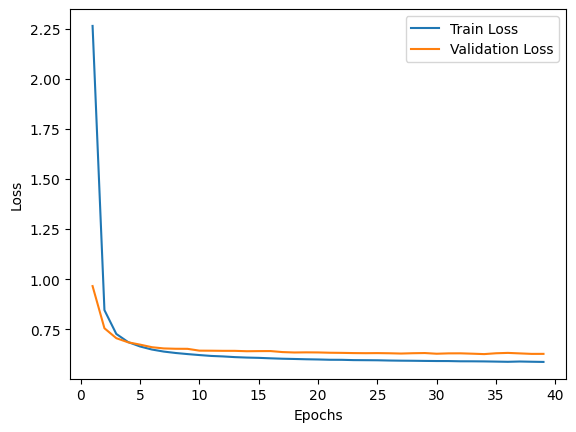

In [18]:
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Check how much of the data is hard to impute due to too big gaps

In [19]:
# Function to check if a list contains >2 consecutive ones
def has_consecutive_ones(anonymous_list):
    count = 0
    for value in anonymous_list:
        if value == 1:
            count += 1
            if count > 2:
                return True
        else:
            count = 0
    return False

df['has_big_gap'] = df['anonymous'].apply(has_consecutive_ones)

print(f"{int(round(len(df[df['has_big_gap']==1])/len(df),2)*100)}% of the paths contain gaps >2 hops")

13% of the paths contain gaps >2 hops


Check a the paths between two sites. Find a trivial case to predict a missing node

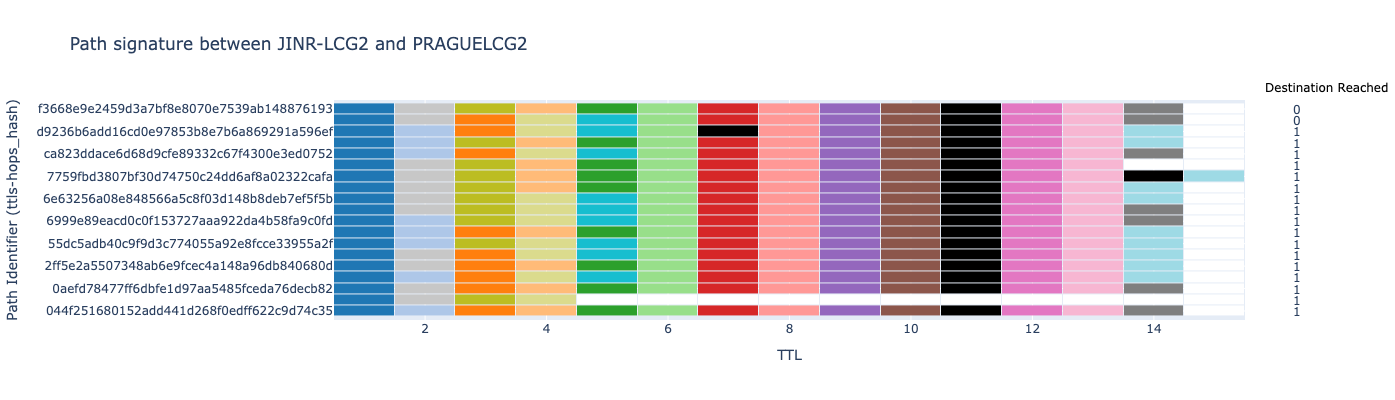

Prediction made for path d9236b6add16cd0e97853b8e7b6a869291a596ef 
 Sequence: ['r795', 'r145', 'r419', 'r163', 'r1048', 'r677', 'r677-unknown-r219', 'r219', 'r159', 'r363', 'r363-unknown-r984', 'r984', 'r471', 'r1213']


In [24]:
import plot_helpers as ph
# incomplete_paths = filled_ipv4[(filled_ipv4['router']=='unknown')]['ttls-hops_hash'].sample(1).values[0]
incomplete_paths = 'd9236b6add16cd0e97853b8e7b6a869291a596ef'
sequence, src, dest, path = df[df['ttls-hops_hash']==incomplete_paths][['curr', 'src_site', 'dest_site', 'ttls-hops_hash']].sample(1).values[0]
ph.generate_plotly_heatmap_with_hover(filled_ipv4[(filled_ipv4['src_site']==src) & (filled_ipv4['dest_site']==dest)], src, dest)
print(f"Prediction made for path {path} \n Sequence: {sequence}")

Make a prediction based on a partial path taken from the above example

In [21]:
# Tokenize and pad the input sequence for prediction
input_sequence = ['r795', 'r145', 'r419', 'r163', 'r1048', 'r677']
tokenized_input = le.transform(input_sequence)
padded_input = pad_sequences([tokenized_input], maxlen=max_len, padding='post', value=0)
input_tensor = torch.tensor(padded_input, dtype=torch.long)
mask = (input_tensor != 0)


model.eval()
with torch.no_grad():
    outputs = model(input_tensor, src_mask=mask)
    # Get the logits for the next token prediction
    # Assuming the last non-padded position
    seq_length = len(tokenized_input)
    next_token_logits = outputs[0, seq_length - 1]
    # Convert logits to probabilities
    probabilities = torch.softmax(next_token_logits, dim=0)
    # Get the most probable token
    predicted_token = torch.argmax(probabilities).item()
    # Convert token back to node
    predicted_node = le.inverse_transform([predicted_token])[0]


print(f"Predicted next node: {predicted_node}")


Predicted next node: r13


Check the transition statistics in case of an unexpected prediction

In [22]:
prob_r1_to_r2 = transition_probabilities.loc['r17','r770']
print("Probability of r17 to r770:", prob_r1_to_r2)

node = 'r677'
print(f"All possible transitions from {node}:")
transition_probabilities.loc[node, transition_probabilities.loc[node] > 0]

Probability of r17 to r770: 0.0
All possible transitions from r677:


next_router
r13     0.997135
r677    0.002865
Name: r677, dtype: float64